In [16]:
#import dan instal library 
!pip install --upgrade plotly
!pip install nlp
!pip install datasets
import tensorflow as tf
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nlp
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping
from keras.layers import GlobalAvgPool1D
import random
import nltk
nltk.download('punkt')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [17]:
#Mengambil Dataset Goemotion dan membagikan data ke dalam data train,test,dan validasi
data = nlp.load_dataset('emotion')

train = pd.DataFrame(data['train'])
validation = pd.DataFrame(data['validation'])
test = pd.DataFrame(data['test'])

Using custom data configuration default


In [18]:
#Menampilkan data train
train.head(15)

,label,text
0,sadness,i didnt feel humiliated
1,sadness,i can go from feeling so hopeless to so damned...
2,anger,im grabbing a minute to post i feel greedy wrong
3,love,i am ever feeling nostalgic about the fireplac...
4,anger,i am feeling grouchy
5,sadness,ive been feeling a little burdened lately wasn...
6,surprise,ive been taking or milligrams or times recomme...
7,fear,i feel as confused about life as a teenager or...
8,joy,i have been with petronas for years i feel tha...
9,love,i feel romantic too


In [19]:
#Memeriksa Label yang unik dari Dataset 
train['label'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [20]:

fig = px.histogram(train, x='label', color='label')
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Distribusi Label',
                  title_x=0.5, title_font=dict(size=22))
fig.show()

In [21]:
#Menentukan Jumlah Frekuensi Klaimat Dalam Dataset Train
FreqOfWords = train['text'].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]

fig = px.treemap(FreqOfWords_top200, path=[FreqOfWords_top200.index], values=0)
fig.update_layout(title_text='Jumlah Kalimat Pada Train Dataset',
                  title_x=0.5, title_font=dict(size=22)
                  )
fig.update_traces(textinfo="label+value")
fig.show()



In [27]:
#Menurut grafik di atas, kata-kata yang paling sering termasuk stopwords seperti "i", "and", "to", dll. Untuk langkah selanjutnya, kata-kata tersebut dihapus.
#Pertama sekali dilakukan adalah Tokenizing dengan NLTK
def tokenization(inputs):
    return word_tokenize(inputs)


train['text_tokenized'] = train['text'].apply(tokenization)
validation['text_tokenized'] = validation['text'].apply(tokenization)

#Dengan menggunakan tokenization, maka akan membagi setiap titik data menjadi kata-kata. 


In [28]:
#Menampilkan Data Train yang telah di Tokenizing
train.head()

,label,text,text_tokenized
0,sadness,i didnt feel humiliated,"[i, didnt, feel, humiliated]"
1,sadness,i can go from feeling so hopeless to so damned...,"[i, can, go, from, feeling, so, hopeless, to, ..."
2,anger,im grabbing a minute to post i feel greedy wrong,"[im, grabbing, a, minute, to, post, i, feel, g..."
3,love,i am ever feeling nostalgic about the fireplac...,"[i, am, ever, feeling, nostalgic, about, the, ..."
4,anger,i am feeling grouchy,"[i, am, feeling, grouchy]"


In [31]:
#Stopwords Remove
#Seperti yang dilihat dari Jumlah Frekuensi Kata dalam visualisasi Train Dataset, kata yang paling sering digunakan adalah stopword bahasa Inggris seperti "i", "you", "their", "to", dll. Pada langkah ini, Menghapus kata-kata ini dari seluruh kumpulan data dengan menggunakan pustaka NLTK.
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def stopwords_remove(inputs):
    return [item for item in inputs if item not in stop_words]

train['text_stop'] = train['text_tokenized'].apply(stopwords_remove)
validation['text_stop'] = validation['text_tokenized'].apply(stopwords_remove)

train.head()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,text,text_tokenized,text_stop
0,sadness,i didnt feel humiliated,"[i, didnt, feel, humiliated]","[didnt, feel, humiliated]"
1,sadness,i can go from feeling so hopeless to so damned...,"[i, can, go, from, feeling, so, hopeless, to, ...","[go, feeling, hopeless, damned, hopeful, aroun..."
2,anger,im grabbing a minute to post i feel greedy wrong,"[im, grabbing, a, minute, to, post, i, feel, g...","[im, grabbing, minute, post, feel, greedy, wrong]"
3,love,i am ever feeling nostalgic about the fireplac...,"[i, am, ever, feeling, nostalgic, about, the, ...","[ever, feeling, nostalgic, fireplace, know, st..."
4,anger,i am feeling grouchy,"[i, am, feeling, grouchy]","[feeling, grouchy]"


In [33]:
#Lemmatization
#Lemmatization adalah proses pengelompokan bersama bentuk-bentuk infleksi yang berbeda dari sebuah kata sehingga mereka dapat dianalisis sebagai satu item. 
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatization(inputs):
    return [lemmatizer.lemmatize(word=x, pos='v') for x in inputs]

train['text_lemmatized'] = train['text_stop'].apply(lemmatization)
validation['text_lemmatized'] = validation['text_stop'].apply(lemmatization)

train.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,label,text,text_tokenized,text_stop,text_lemmatized
0,sadness,i didnt feel humiliated,"[i, didnt, feel, humiliated]","[didnt, feel, humiliated]","[didnt, feel, humiliate]"
1,sadness,i can go from feeling so hopeless to so damned...,"[i, can, go, from, feeling, so, hopeless, to, ...","[go, feeling, hopeless, damned, hopeful, aroun...","[go, feel, hopeless, damn, hopeful, around, so..."
2,anger,im grabbing a minute to post i feel greedy wrong,"[im, grabbing, a, minute, to, post, i, feel, g...","[im, grabbing, minute, post, feel, greedy, wrong]","[im, grab, minute, post, feel, greedy, wrong]"
3,love,i am ever feeling nostalgic about the fireplac...,"[i, am, ever, feeling, nostalgic, about, the, ...","[ever, feeling, nostalgic, fireplace, know, st...","[ever, feel, nostalgic, fireplace, know, still..."
4,anger,i am feeling grouchy,"[i, am, feeling, grouchy]","[feeling, grouchy]","[feel, grouchy]"


In [34]:
train['text_cleaned'] = train['text_lemmatized'].str.join(' ')
validation['text_cleaned'] = validation['text_lemmatized'].str.join(' ')

train.head() #hasi final dari dataset setelah dilakukan tokenizing,stopwords,dan lemmatized 

,label,text,text_tokenized,text_stop,text_lemmatized,text_cleaned
0,sadness,i didnt feel humiliated,"[i, didnt, feel, humiliated]","[didnt, feel, humiliated]","[didnt, feel, humiliate]",didnt feel humiliate
1,sadness,i can go from feeling so hopeless to so damned...,"[i, can, go, from, feeling, so, hopeless, to, ...","[go, feeling, hopeless, damned, hopeful, aroun...","[go, feel, hopeless, damn, hopeful, around, so...",go feel hopeless damn hopeful around someone c...
2,anger,im grabbing a minute to post i feel greedy wrong,"[im, grabbing, a, minute, to, post, i, feel, g...","[im, grabbing, minute, post, feel, greedy, wrong]","[im, grab, minute, post, feel, greedy, wrong]",im grab minute post feel greedy wrong
3,love,i am ever feeling nostalgic about the fireplac...,"[i, am, ever, feeling, nostalgic, about, the, ...","[ever, feeling, nostalgic, fireplace, know, st...","[ever, feel, nostalgic, fireplace, know, still...",ever feel nostalgic fireplace know still property
4,anger,i am feeling grouchy,"[i, am, feeling, grouchy]","[feeling, grouchy]","[feel, grouchy]",feel grouchy


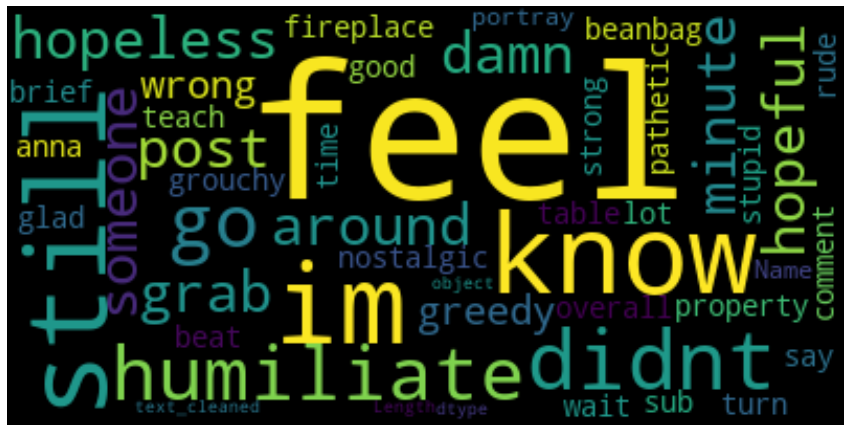

In [35]:
#WordCloud dari Dataset yang Dibersihkan
WordCloud = WordCloud(max_words=100,
                      random_state=30,
                      collocations=True).generate(str((train['text_cleaned'])))

plt.figure(figsize=(15, 8))
plt.imshow(WordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()